In [126]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
%matplotlib inline
sns.set(rc={'figure.figsize':(8,3)})
from IPython.display import display, HTML
pd.options.display.float_format = '{:5,.2f}'.format
from sklearn.metrics import mean_squared_error
from itertools import combinations
import time
import pickle

# Exploratory Data Analysis

In [101]:
def ploting_dist(df,variable,bins=33):
    df[variable].hist(bins=bins)
    display(pd.DataFrame(df[variable].describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99])).T)
    plt.show()
    return 

def EDA_categorical(variable):
    print(variable)
    summary = train[[variable,'User_ID','Product_ID','Purchase']]\
                .groupby(variable)\
                .agg({  'User_ID':['nunique'],
                        'Product_ID':['nunique'],
                        'Purchase':['count','sum'],
                     }).reset_index()
    summary.columns = [variable,'unq_clients','unq_products','cnt_transactions','total_amount']
    summary['avg_purchase_cnt_x_client'] = summary['cnt_transactions']/summary['unq_clients']
    summary['avg_purchase_amt_x_client'] = summary['total_amount']/summary['unq_clients']
    summary['avg_price_x_product'] = summary['total_amount']/summary['cnt_transactions']
    summary = summary.sort_values(variable)
    sns.barplot(summary[variable],summary['cnt_transactions'])
    plt.show()
    sns.barplot(summary[variable],summary['avg_price_x_product'])
    plt.show()
    sns.barplot(summary[variable],summary['total_amount'])
    plt.show()
    display(HTML(summary.to_html()))
    print('*** TRANSACCIONES POR {} ***'.format(variable))
    a = summary['cnt_transactions']/summary['unq_clients']
    b=a[0]-a[len(a)-1]
    print('Change: {0:5,.2f} ({1:2.2f}%)'.format(b,(b*100.0)/a[len(a)-1]))
    print('*** MONTOS POR {} ***'.format(variable))
    a = summary['total_amount']/summary['unq_clients']
    b=a[0]-a[len(a)-1]
    print('Change: {0:5,.2f} ({1:2.2f}%)'.format(b,(b*100.0)/a[len(a)-1]))
    return summary

def categories(x, ranges):
    nr=len(ranges)
    for nr_indx in range(nr):
        if x <= ranges[nr_indx]: return nr_indx
    return nr_indx

def stability_index(df_new, df_original, variable, pct=10):
    df_original['rnk'] = pd.qcut(df_original[variable],pct,labels=False,duplicates='drop')
    train_table = df_original[['User_ID', 'rnk', variable]].groupby('rnk', as_index=False).agg({variable:['min','max','count']})
    train_table.columns = ['rnk','min_bnd','max_bnd','freq_train']
    ranges_table = train_table.sort_values(by='rnk')
    ranges = ranges_table.max_bnd
    df_new['rnk'] = df_new[variable].apply(lambda x: categories(x,ranges))
    df_table = df[['rnk',variable]].groupby('rnk', as_index=False).count()
    df_table.columns = ['rnk','freq_new']
    # join tables
    si_table = pd.merge(ranges_table, df_table, on='rnk', how='left').fillna(0).sort_values(by='rnk')
    si_table['pct_freq_train'] = si_table['freq_train']/si_table['freq_train'].sum()
    si_table['pct_freq_new'] = si_table['freq_new']/si_table['freq_new'].sum()
    si_table['stability_index'] = (si_table['pct_freq_new']-si_table['pct_freq_train'])*np.log(si_table['pct_freq_new']/si_table['pct_freq_train'])
    stability_index = si_table['stability_index'].sum()
    si_table['feature'] = variable
    cols = ['feature','rnk','min_bnd','max_bnd','freq_train','freq_new','pct_freq_train','pct_freq_new','stability_index']
    return si_table[cols], stability_index

def distribution(df,variable):
    d = pd.DataFrame(df[variable].describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99])).T
    d = d.reset_index().drop('index',axis=1)
    d['feature'] = variable
    return d[[d.columns[-1]] + list(d.columns[:-1])]

def control1(df):
    all_dist = pd.DataFrame()
    for x in x_vars + [y_vars]:
        a = distribution(df, x)
        all_dist = pd.concat([all_dist,a])
    return all_dist

In [54]:
df = pd.read_csv('txn_train.csv')
n_data = len(df)
# msk = np.random.rand(len(df)) < 0.80
train = df[msk].copy()
n_train = len(train)
test = df[~msk].copy()
n_test = len(test)
print('Hay {0:5,.0f}({1:2.2f}%) observaciones en total'.format(n_data,n_data*100.0/n_data))
print('Hay {0:5,.0f}({1:2.2f}%) observaciones para entrenar'.format(n_train,n_train*100.0/n_data))
print('${0:5,.0f} en transacciones | ${1:5,.0f} en promedio'.format(train.Purchase.sum(),train.Purchase.mean()))
print('Hay {0:5,.0f}({1:2.2f}%) observaciones para validar'.format(n_test,n_test*100.0/n_data))

Hay 50,000(100.00%) observaciones en total
Hay 40,051(80.10%) observaciones para entrenar
$373,459,012 en transacciones | $9,325 en promedio
Hay 9,949(19.90%) observaciones para validar


##### Supuesto: las compras están en pesos mexicanos

In [56]:
train.shape

(40051, 12)

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40051 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     40051 non-null  int64  
 1   Product_ID                  40051 non-null  object 
 2   Gender                      40051 non-null  object 
 3   Age                         40051 non-null  object 
 4   Occupation                  40051 non-null  int64  
 5   City_Category               40051 non-null  object 
 6   Stay_In_Current_City_Years  40051 non-null  object 
 7   Marital_Status              40051 non-null  int64  
 8   Product_Category_1          40051 non-null  int64  
 9   Product_Category_2          27466 non-null  float64
 10  Product_Category_3          12253 non-null  float64
 11  Purchase                    40051 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 4.0+ MB


In [58]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1004122,P00238542,M,18-25,19,C,4+,0,5,14.0,NaN,3522
2,1002931,P00042842,M,18-25,4,B,2,0,5,NaN,NaN,3456
3,1003808,P00195342,M,26-35,7,A,2,1,2,5.0,NaN,13288
4,1004950,P0099242,M,26-35,16,A,1,1,8,14.0,NaN,5915
5,1003736,P00210042,M,36-45,1,C,1,1,8,14.0,NaN,5841


In [59]:
train.tail()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
49994,1001586,P00193642,M,46-50,7,B,2,1,2,3.0,4.0,13231
49995,1001764,P00015542,M,18-25,0,B,1,0,1,2.0,13.0,15656
49996,1005925,P00205942,F,26-35,0,C,1,1,5,8.0,14.0,6863
49998,1003224,P00037542,F,26-35,14,A,3,1,1,NaN,NaN,7866
49999,1001627,P00057642,M,18-25,17,A,3,1,1,15.0,16.0,15462


### Preliminares:
* **Key parameters:** User_ID Product_ID
* **Variables independientes (todas categóricas):** Gender, Age, Occupation, City_Category, Stay_In_Current_City_Years, Marital_Status, Product_Category_1, Product_Category_2, Product_Category_3
* **Variable dependiente (continua):** Purchase
* **Missings:** Product_Category_2, Product_Category_3


### User_ID

In [60]:
clients = train['User_ID'].value_counts()
n_clients = len(clients)
avg_puchases = len(train['User_ID'])*1.0/n_clients
avg_amount = train['Purchase'].sum()*1.0/n_clients
print('Hay {0:5,.0f} clientes únicos con {1:2,.0f} transacciones por {2:5,.0f} en promedio'.format(n_clients, avg_puchases, avg_amount))

Hay 5,338 clientes únicos con  8 transacciones por 69,962 en promedio


In [61]:
summary = train[['User_ID','Purchase']].groupby('User_ID').agg({'sum','count','mean'}).reset_index()
summary

User_ID      Purchase              
                       mean     sum count
0     1000001   2849.000000    2849     1
1     1000002  11915.500000   47662     4
2     1000003  11767.500000   47070     4
3     1000005   9662.230769  125609    13
4     1000006   6954.000000    6954     1
...       ...           ...     ...   ...
5333  1006035   3196.200000   15981     5
5334  1006036   7977.263158  303136    38
5335  1006037   8708.300000   87083    10
5336  1006039  10552.000000   10552     1
5337  1006040   9159.812500  146557    16

[5338 rows x 4 columns]

In [69]:
summary = train[['User_ID','Purchase']].groupby('User_ID').agg({'sum','count','mean'}).reset_index()
summary.columns = ['User_ID','avg_amount','total_amount','count_transactions']
print('TOP CLIENTS:')
summary.sort_values('total_amount', ascending=False).head(10)

TOP CLIENTS:


,User_ID,avg_amount,total_amount,count_transactions
3766,1004277,11508.787879,759580,66
3922,1004448,11942.116667,716527,60
1476,1001680,8734.725000,698778,80
3173,1003618,8587.449275,592534,69
2663,1003032,10818.188679,573364,53
375,1000424,9340.745763,551104,59
2554,1002909,11465.600000,515952,45
1703,1001941,8586.610169,506610,59
942,1001088,9111.781818,501148,55
481,1000550,9792.392157,499412,51


### **Los mejores clientes gastan más de medio millon en total de compras**

In [71]:
(summary.total_amount>=100000).sum()

1218

In [72]:
(summary.total_amount>=500000).sum()

9

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
avg_amount,5338.0,9646.163996,3372.848446,24.0,1921.47,4816.4,5915.253333,7590.55,9268.541667,11449.75,13927.595,15732.5,19492.21,23710.0


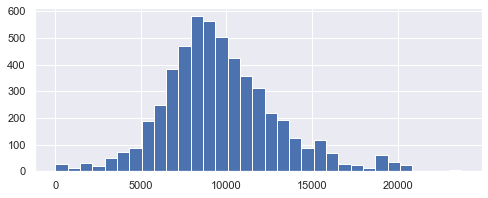

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
count_transactions,5338.0,7.502997,8.353651,1.0,1.0,1.0,1.0,2.0,4.0,10.0,18.0,25.0,41.63,80.0


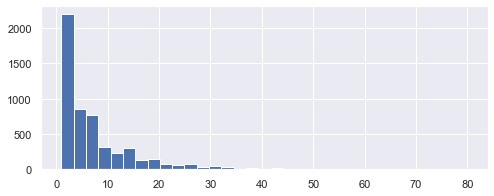

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
total_amount,5338.0,69962.347696,75586.6651,24.0,2051.81,6896.85,9512.2,19886.25,43333.5,92834.0,163973.4,222891.25,358482.1,759580.0


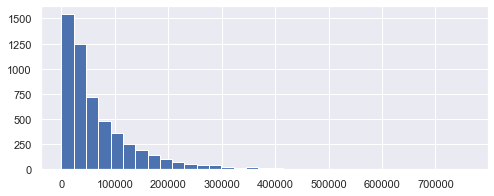

In [73]:
ploting_dist(summary,'avg_amount')
ploting_dist(summary,'count_transactions')
ploting_dist(summary,'total_amount')

## Product_ID

In [74]:
products = train['Product_ID'].value_counts()
n_products = len(products)
avg_puchases = len(train['Product_ID'])*1.0/n_products
avg_amount = train['Purchase'].sum()*1.0/n_products
print('Hay {0:5,.0f} productos con {1:2,.0f} transacciones por {2:5,.0f} en promedio'.format(n_products, avg_puchases, avg_amount))

Hay 2,998 productos con 13 transacciones por 124,569 en promedio


In [75]:
train[["Product_ID",'Purchase']].drop_duplicates()['Product_ID'].value_counts()[:3]

P00025442    135
P00265242    129
P00059442    125
Name: Product_ID, dtype: int64

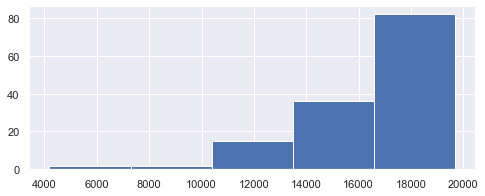

In [76]:
train[train.Product_ID=='P00025442']['Purchase'].hist(bins=5)

### **Un mismo producto no tiene el mismo precio y puede variar bastante (X veces más)**

In [77]:
summary = train[['Product_ID','User_ID','Purchase']].groupby('Product_ID').agg({'User_ID':['nunique'],'Purchase':['sum','count','mean']}).reset_index()
summary.columns = ['Product_ID','unq_clients','total_amount','count_transactions','avg_amount']
print('TOP PRODUCTS:')
summary.sort_values('total_amount', ascending=False).head(10)

TOP PRODUCTS:


,Product_ID,unq_clients,total_amount,count_transactions,avg_amount
209,P00025442,137,2349585,137,17150.255474
823,P00110942,130,2304301,130,17725.392308
502,P00059442,127,2187568,127,17224.944882
821,P00110742,121,1995676,121,16493.190083
835,P00112142,121,1903212,121,15729.024793
2021,P00255842,99,1804250,99,18224.747475
1110,P00145042,123,1795713,123,14599.292683
1432,P00184942,105,1742576,105,16595.961905
399,P00046742,119,1705168,119,14329.142857
487,P00057642,103,1622211,103,15749.621359


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
avg_amount,"2,998.00","8,002.41","4,041.49",38.33,764.18,"2,280.61","3,580.10","5,345.44","7,098.98","10,298.41","14,358.97","16,055.27","18,534.43","22,119.52"


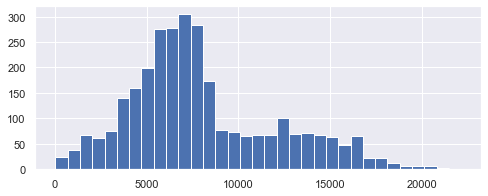

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
count_transactions,"2,998.00",13.36,16.66,1.00,1.00,1.00,1.00,3.00,7.00,17.00,34.00,46.00,81.00,137.00


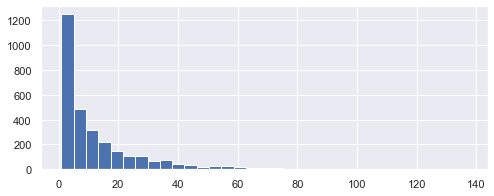

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
total_amount,"2,998.00","124,569.38","213,886.30",219.00,"1,906.76","4,556.80","7,068.30","16,289.50","48,615.00","141,145.75","314,616.50","483,416.15","1,088,343.39","2,349,585.00"


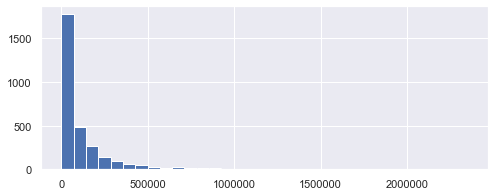

In [80]:
ploting_dist(summary,'avg_amount')
ploting_dist(summary,'count_transactions')
ploting_dist(summary,'total_amount')

### **Dos tipos de productos:**
* #### Volumen alto y precio bajo, de 3.5K a 10K (basics)
* #### Volumen bajo y precio alto, de 10K a 18.6K (premium)


In [96]:
prod_1m = summary[summary.total_amount>=1000000]
a = prod_1m.sort_values('total_amount', ascending=False)
display(a.head(10))
len(a)

,Product_ID,unq_clients,total_amount,count_transactions,avg_amount
209,P00025442,137,2349585,137,"17,150.26"
823,P00110942,130,2304301,130,"17,725.39"
502,P00059442,127,2187568,127,"17,224.94"
821,P00110742,121,1995676,121,"16,493.19"
835,P00112142,121,1903212,121,"15,729.02"
2021,P00255842,99,1804250,99,"18,224.75"
1110,P00145042,123,1795713,123,"14,599.29"
1432,P00184942,105,1742576,105,"16,595.96"
399,P00046742,119,1705168,119,"14,329.14"
487,P00057642,103,1622211,103,"15,749.62"


35

### **El 1% de los productos tienen ventas de más de un millon, hay productos estrella con muchas ventas y altos montos**

### Hay muchos clientes y muchos productos, al no ser posible tratarlos de forma numérica, se podría explorar la opción de un análisis de componentes o un matrix factorization para extraer ciertas características y reducir la dimensionalidad que habría si se usaran variables dummy**

## Transformaciones y variables independientes:

In [82]:
def basicTransform(df_clean):
    df_clean["Gender"] = df_clean["Gender"].apply(lambda x: {'F':0, 'M':1}[x])
    df_clean["Age"] = df_clean["Age"].apply(lambda x: {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}[x])
    df_clean["City_Category"] = df_clean["City_Category"].apply(lambda x: {'A':0, 'B':1, 'C':2}[x])
    df_clean["Stay_In_Current_City_Years"] = df_clean["Stay_In_Current_City_Years"].apply(lambda x: {'0':0, '1':1, '2':2, '3':3, '4+':4}[x])
    return df_clean

def missing_treatment(df_clean):
    miss_val = -999
    df_clean = df_clean.fillna(miss_val)
    df_clean.Product_Category_2 = df_clean.Product_Category_2.astype(np.int64)
    df_clean.Product_Category_3 = df_clean.Product_Category_3.astype(np.int64)
    return df_clean


train = df[msk].copy()
test = df[~msk].copy()

train = basicTransform(train)
test = basicTransform(test)

train = missing_treatment(train)
test = missing_treatment(test)

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40051 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   User_ID                     40051 non-null  int64 
 1   Product_ID                  40051 non-null  object
 2   Gender                      40051 non-null  int64 
 3   Age                         40051 non-null  int64 
 4   Occupation                  40051 non-null  int64 
 5   City_Category               40051 non-null  int64 
 6   Stay_In_Current_City_Years  40051 non-null  int64 
 7   Marital_Status              40051 non-null  int64 
 8   Product_Category_1          40051 non-null  int64 
 9   Product_Category_2          40051 non-null  int64 
 10  Product_Category_3          40051 non-null  int64 
 11  Purchase                    40051 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 4.0+ MB


In [84]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9949 entries, 1 to 49997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   User_ID                     9949 non-null   int64 
 1   Product_ID                  9949 non-null   object
 2   Gender                      9949 non-null   int64 
 3   Age                         9949 non-null   int64 
 4   Occupation                  9949 non-null   int64 
 5   City_Category               9949 non-null   int64 
 6   Stay_In_Current_City_Years  9949 non-null   int64 
 7   Marital_Status              9949 non-null   int64 
 8   Product_Category_1          9949 non-null   int64 
 9   Product_Category_2          9949 non-null   int64 
 10  Product_Category_3          9949 non-null   int64 
 11  Purchase                    9949 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 1010.4+ KB


## GENDER

Gender


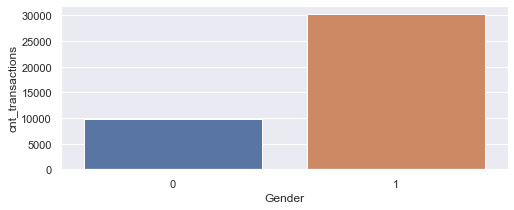

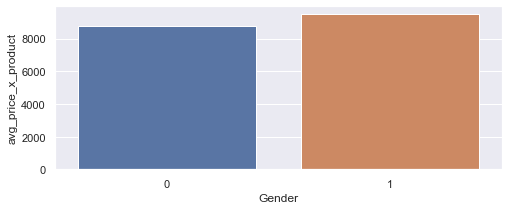

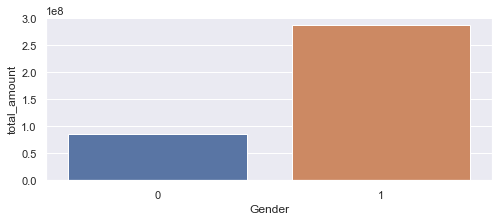

,Gender,unq_clients,unq_products,cnt_transactions,total_amount,avg_purchase_cnt_x_client,avg_purchase_amt_x_client,avg_price_x_product
0,0,1497,2243,9828,86350416,6.57,"57,682.31","8,786.16"
1,1,3841,2849,30223,287108596,7.87,"74,748.40","9,499.67"


*** TRANSACCIONES POR Gender ***
Change: -1.30 (-16.56%)
*** MONTOS POR Gender ***
Change: -17,066.09 (-22.83%)


In [102]:
s = EDA_categorical('Gender')

#### Los hombres hacen más compras y por montos mayores:

##### En promedio 1.35 más compras (19%) y gastan hasta 28% más (arriba de 17K)

## Marital_Status
Supuesto: 1 es casado y 0 cualquier otro caso

Marital_Status


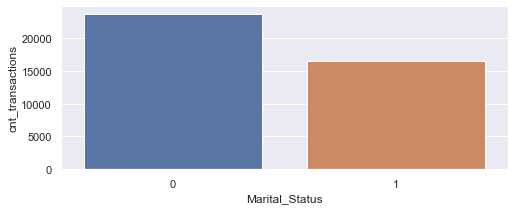

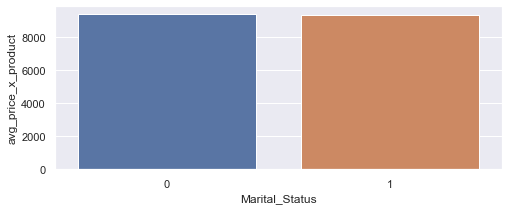

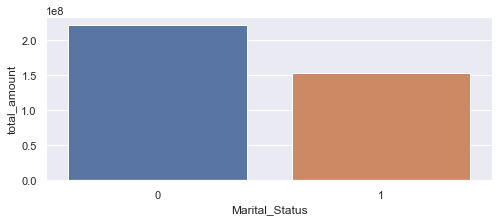

,Marital_Status,unq_clients,unq_products,cnt_transactions,total_amount,avg_purchase_cnt_x_client,avg_purchase_amt_x_client,avg_price_x_product
0,0,3110,2724,23616,221064671,7.59,"71,081.89","9,360.80"
1,1,2228,2629,16435,152394341,7.38,"68,399.61","9,272.55"


*** TRANSACCIONES POR Marital_Status ***
Change:  0.22 (2.94%)
*** MONTOS POR Marital_Status ***
Change: 2,682.27 (3.92%)


In [103]:
s = EDA_categorical('Marital_Status')

**Hay más clientes no casados y estos a su vez hacen más compras (3% más) con montos mayores (4% más)**

## Age

Age


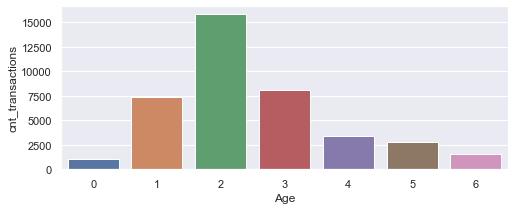

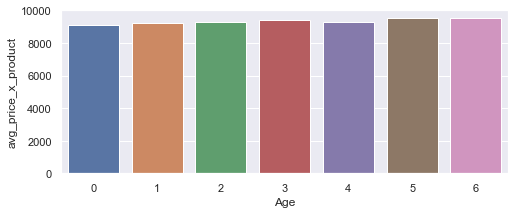

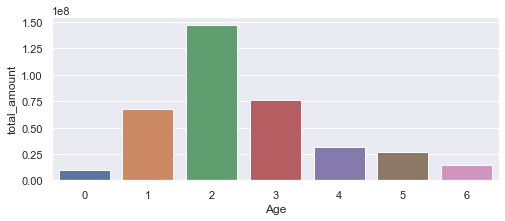

,Age,unq_clients,unq_products,cnt_transactions,total_amount,avg_purchase_cnt_x_client,avg_purchase_amt_x_client,avg_price_x_product
0,0,199,732,1076,9788872,5.41,"49,190.31","9,097.46"
1,1,979,1931,7345,67883085,7.50,"69,339.21","9,242.08"
2,2,1862,2490,15861,147138618,8.52,"79,021.81","9,276.76"
3,3,1060,2115,8054,76012147,7.60,"71,709.57","9,437.81"
4,4,475,1508,3398,31501042,7.15,"66,317.98","9,270.47"
5,5,434,1319,2772,26409529,6.39,"60,851.45","9,527.25"
6,6,329,916,1545,14725719,4.70,"44,759.02","9,531.21"


*** TRANSACCIONES POR Age ***
Change:  0.71 (15.14%)
*** MONTOS POR Age ***
Change: 4,431.29 (9.90%)


In [104]:
s = EDA_categorical('Age')

**Se puede observar que las personas jóvenes, mayores de edad, son los clientes más activos.**

**Sin embargo, los clientes de mayor edad hacen compras por montos mucho mayores**

**Posible feature: segmentos 0-17, 18-45, 46-55 y 55+**

## Occupation

Occupation


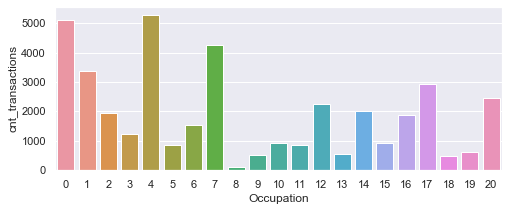

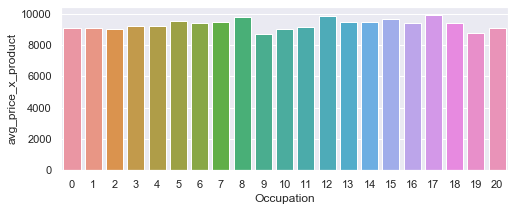

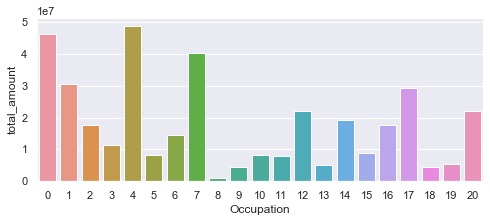

,Occupation,unq_clients,unq_products,cnt_transactions,total_amount,avg_purchase_cnt_x_client,avg_purchase_amt_x_client,avg_price_x_product
0,0,628,1879,5094,46318594,8.11,"73,755.72","9,092.77"
1,1,460,1487,3358,30484797,7.30,"66,271.30","9,078.26"
2,2,235,1119,1938,17525155,8.25,"74,575.13","9,042.91"
3,3,154,839,1222,11229596,7.94,"72,919.45","9,189.52"
4,4,680,1745,5277,48752051,7.76,"71,694.19","9,238.59"
5,5,99,648,870,8308446,8.79,"83,923.70","9,549.94"
6,6,197,980,1534,14472674,7.79,"73,465.35","9,434.60"
7,7,590,1663,4259,40328360,7.22,"68,353.15","9,468.97"
8,8,13,115,117,1144606,9.00,"88,046.62","9,782.96"
9,9,78,419,511,4434485,6.55,"56,852.37","8,678.05"


*** TRANSACCIONES POR Occupation ***
Change: -1.45 (-15.21%)
*** MONTOS POR Occupation ***
Change: -12,962.46 (-14.95%)


In [105]:
s = EDA_categorical('Occupation')

**Es evidente que la ocupación del cliente afecta al poder adquisitivo y por lo tanto al nivel de compras que realiza.**

## City_Category

City_Category


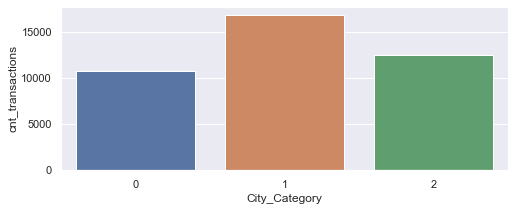

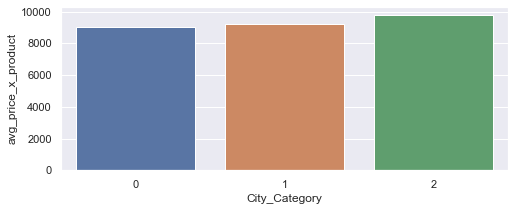

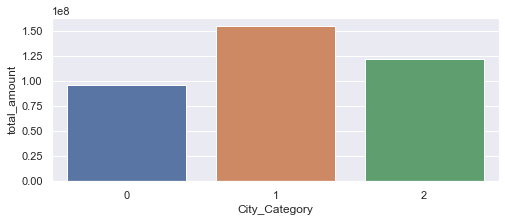

,City_Category,unq_clients,unq_products,cnt_transactions,total_amount,avg_purchase_cnt_x_client,avg_purchase_amt_x_client,avg_price_x_product
0,0,961,2415,10722,96438093,11.16,"100,351.81","8,994.41"
1,1,1612,2622,16862,155028368,10.46,"96,171.44","9,193.95"
2,2,2765,2226,12467,121992551,4.51,"44,120.27","9,785.24"


*** TRANSACCIONES POR City_Category ***
Change:  6.65 (147.45%)
*** MONTOS POR City_Category ***
Change: 56,231.54 (127.45%)


In [106]:
s = EDA_categorical('City_Category')

**Hay una posible jerarquía en el nivel de transacciones por ciudad, sin ver más detalle no se sabe si es por cuestion de tamaño, densidad poblacional, nivel de ingresos, etc, sin embargo puede ayudar en una estrategia de segmentación de campañas.**

## Stay_In_Current_City_Years

Stay_In_Current_City_Years


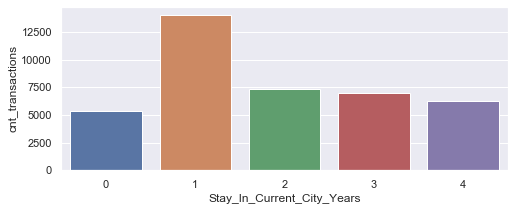

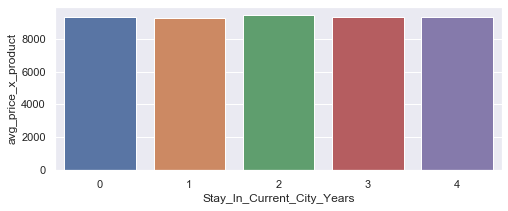

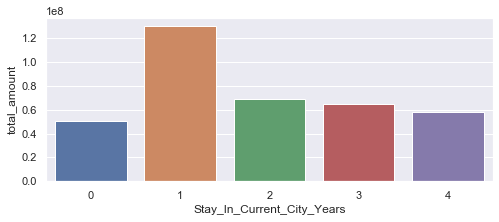

,Stay_In_Current_City_Years,unq_clients,unq_products,cnt_transactions,total_amount,avg_purchase_cnt_x_client,avg_purchase_amt_x_client,avg_price_x_product
0,0,707,1868,5384,50207673,7.62,"71,015.10","9,325.35"
1,1,1885,2463,14053,130338571,7.46,"69,145.13","9,274.79"
2,2,1025,2044,7354,69432515,7.17,"67,739.04","9,441.46"
3,3,890,2015,6989,65239307,7.85,"73,302.59","9,334.57"
4,4,831,1956,6271,58240946,7.55,"70,085.37","9,287.35"


*** TRANSACCIONES POR Stay_In_Current_City_Years ***
Change:  0.07 (0.91%)
*** MONTOS POR Stay_In_Current_City_Years ***
Change: 929.72 (1.33%)


In [110]:
s = EDA_categorical('Stay_In_Current_City_Years')

User_ID
Stay_In_Current_City_Years Age         
0                          0        165
                           1       1216
                           2       1986
                           3       1001
                           4        472
                           5        322
                           6        222
1                          0        368
                           1       2380
                           2       5639
                           3       2663
                           4       1266
                           5       1212
                           6        525
2                          0        238
                           1       1408
                           2       2798
                           3       1555
                           4        632
                           5        436
                           6        287
3                          0        198
                           1       1135
                           2       2872
                           3       1696
                           4        438
                           5        395
                           6        255
4                          0        107
                           1       1206
                           2       2566
                           3       1139
                           4        590
                           5        407
                           6        256

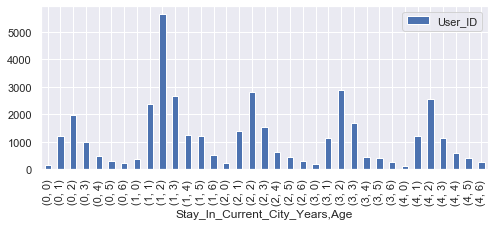

In [112]:
display(train[['Stay_In_Current_City_Years','Age','User_ID']].groupby(['Stay_In_Current_City_Years','Age']).count())
train[['Stay_In_Current_City_Years','Age','User_ID']].groupby(['Stay_In_Current_City_Years','Age']).count().plot(kind='bar')

**El que los clientes con 1 año de antiguedad tengan mayor nivel de compras podría deberse a que necesitan comprar productos "home & lifestyle" para una vida que comienza a independizarse (mayor densidad de clientes en los 20's), aunque tendría que verse el detalle para confirmar. Si la compañía cuenta con socios comerciales en industrias "H&L" podría ser un área con mucho potencial para ofertas personalizadas.**

## Product_Category_1

Product_Category_1


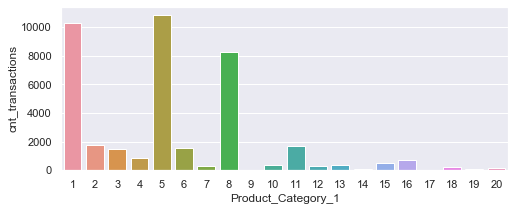

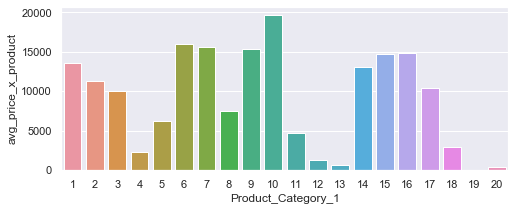

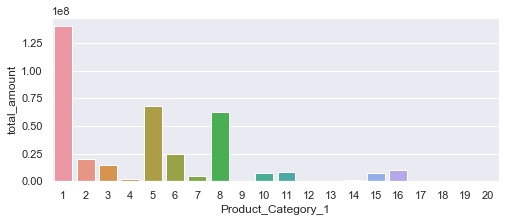

,Product_Category_1,unq_clients,unq_products,cnt_transactions,total_amount,avg_purchase_cnt_x_client,avg_purchase_amt_x_client,avg_price_x_product
0,1,3413,455,10310,140584056,3.02,"41,190.76","13,635.70"
1,2,1245,132,1768,20053781,1.42,"16,107.45","11,342.64"
2,3,1019,84,1453,14653677,1.43,"14,380.45","10,085.12"
3,4,708,77,880,2038707,1.24,"2,879.53","2,316.71"
4,5,3439,802,10867,67758513,3.16,"19,702.97","6,235.25"
5,6,1146,98,1561,24961042,1.36,"21,781.01","15,990.42"
6,7,243,62,283,4431886,1.16,"18,238.21","15,660.37"
7,8,3096,825,8301,62341943,2.68,"20,136.29","7,510.17"
8,9,23,1,23,352338,1.00,"15,319.04","15,319.04"
9,10,330,18,363,7147550,1.10,"21,659.24","19,690.22"


*** TRANSACCIONES POR Product_Category_1 ***
Change:  2.02 (202.08%)
*** MONTOS POR Product_Category_1 ***
Change: 40,805.84 (10601.06%)


In [113]:
s = EDA_categorical('Product_Category_1')

# MODELING

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40051 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   User_ID                     40051 non-null  int64 
 1   Product_ID                  40051 non-null  object
 2   Gender                      40051 non-null  int64 
 3   Age                         40051 non-null  int64 
 4   Occupation                  40051 non-null  int64 
 5   City_Category               40051 non-null  int64 
 6   Stay_In_Current_City_Years  40051 non-null  int64 
 7   Marital_Status              40051 non-null  int64 
 8   Product_Category_1          40051 non-null  int64 
 9   Product_Category_2          40051 non-null  int64 
 10  Product_Category_3          40051 non-null  int64 
 11  Purchase                    40051 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 5.2+ MB


In [115]:
def reg_metrics(y_true, y_pred):
    # Root Mean Squared Error
    RMSE = metrics.mean_squared_error(y_true, y_pred, squared=False)
    return RMSE

In [116]:
x_vars = ['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3']
y_vars = 'Purchase'

## Modelo Base

In [127]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [34]:
regressors = [LinearRegression(),SVR(kernel='rbf', gamma='auto'),
              DecisionTreeRegressor(),RandomForestRegressor(),
              GradientBoostingRegressor(),MLPRegressor()]
for reg in regressors:
    name = reg.__class__.__name__
    reg.fit(train[x_vars], train[y_vars])
    rmse = mean_squared_error(test[y_vars], reg.predict(test[x_vars]), squared=False)
    print("{0} | RMSE on test set: {1:5,.0f}".format(name,rmse))

LinearRegression | RMSE on test set: 4,645
SVR | RMSE on test set: 5,124
DecisionTreeRegressor | RMSE on test set: 3,851
RandomForestRegressor | RMSE on test set: 3,125
GradientBoostingRegressor | RMSE on test set: 3,001
MLPRegressor | RMSE on test set: 4,333


C:\Users\gusar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Modelo principal

### Basic numerical transformation for categorical variables

In [136]:
x_vars = ['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3']
y_vars = 'Purchase'
train = df[msk].copy()
test = df[~msk].copy()
train = basicTransform(train)
test = basicTransform(test)

In [137]:
display(control1(train))

,feature,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
0,Gender,"40,051.00",0.75,0.43,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
0,Age,"40,051.00",2.50,1.35,0.00,0.00,1.00,1.00,2.00,2.00,3.00,5.00,5.00,6.00,6.00
0,Occupation,"40,051.00",8.11,6.53,0.00,0.00,0.00,0.00,2.00,7.00,14.00,17.00,20.00,20.00,20.00
0,City_Category,"40,051.00",1.04,0.76,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2.00,2.00,2.00,2.00
0,Stay_In_Current_City_Years,"40,051.00",1.87,1.29,0.00,0.00,0.00,0.00,1.00,2.00,3.00,4.00,4.00,4.00,4.00
0,Marital_Status,"40,051.00",0.41,0.49,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00
0,Product_Category_1,"40,051.00",5.38,3.92,1.00,1.00,1.00,1.00,1.00,5.00,8.00,11.00,13.00,18.00,20.00
0,Product_Category_2,"27,466.00",9.79,5.09,2.00,2.00,2.00,2.00,5.00,9.00,15.00,16.00,16.00,17.00,18.00
0,Product_Category_3,"12,253.00",12.65,4.12,3.00,4.00,5.00,5.00,9.00,14.00,16.00,17.00,17.00,18.00,18.00
0,Purchase,"40,051.00","9,324.59","5,034.09",12.00,598.50,"1,998.00","3,541.00","5,866.00","8,070.00","12,099.00","16,370.00","19,361.00","20,654.00","23,961.00"


### MISSING TREATMENT

In [138]:
train = missing_treatment(train)
test = missing_treatment(test)

In [139]:
last_dist = control1(train)
display(last_dist)

,feature,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
0,Gender,"40,051.00",0.75,0.43,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
0,Age,"40,051.00",2.50,1.35,0.00,0.00,1.00,1.00,2.00,2.00,3.00,5.00,5.00,6.00,6.00
0,Occupation,"40,051.00",8.11,6.53,0.00,0.00,0.00,0.00,2.00,7.00,14.00,17.00,20.00,20.00,20.00
0,City_Category,"40,051.00",1.04,0.76,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2.00,2.00,2.00,2.00
0,Stay_In_Current_City_Years,"40,051.00",1.87,1.29,0.00,0.00,0.00,0.00,1.00,2.00,3.00,4.00,4.00,4.00,4.00
0,Marital_Status,"40,051.00",0.41,0.49,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00
0,Product_Category_1,"40,051.00",5.38,3.92,1.00,1.00,1.00,1.00,1.00,5.00,8.00,11.00,13.00,18.00,20.00
0,Product_Category_2,"40,051.00",-307.20,468.31,-999.00,-999.00,-999.00,-999.00,-999.00,5.00,14.00,16.00,16.00,17.00,18.00
0,Product_Category_3,"40,051.00",-689.50,466.18,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,8.00,15.00,16.00,17.00,18.00
0,Purchase,"40,051.00","9,324.59","5,034.09",12.00,598.50,"1,998.00","3,541.00","5,866.00","8,070.00","12,099.00","16,370.00","19,361.00","20,654.00","23,961.00"


### CAPPING AND FLOORING

In [140]:
# No se puede realizar ya que todos los features son categóricos
# cap_n_flr_bnd = last_dist[['feature','1%','99%']].reset_index().drop('index',axis=1)
# for x in x_vars:
#     cutoff_min = cap_n_flr_bnd[cap_n_flr_bnd.feature==x]['1%']
#     cutoff_max = cap_n_flr_bnd[cap_n_flr_bnd.feature==x]['99%']
#     train.ix[train[x] < cutoff_purchase, x] = cutoff_min
#     train.ix[train[x] > cutoff_purchase, x] = cutoff_max
#     test.ix[test[x] < cutoff_purchase, x] = cutoff_min
#     test.ix[test[x] > cutoff_purchase, x] = cutoff_max
# display(control1(train))

### FEATURE ENGINEERING AND FEATURE SELECTION

In [141]:
def get_sort_dict(variable):
    msk = np.random.rand(len(df)) < 0.80
    base = df[msk].copy()
    base = base.fillna(0)
    base = basicTransform(base)
    a = base[[variable,'Purchase']].groupby(variable).sum().reset_index().sort_values(by='Purchase').reset_index().drop('index',axis=1)
    return {a[variable][v]:v for v in range(len(a[variable]))}
# DUMMY VARIABLES
def get_dummy(df,variable):
    a = pd.get_dummies(data=df[variable])
    a.columns = [variable.lower() + '_d'+str(i) for i in range(len(a.columns))]
    table = pd.concat([df, a], axis=1)
    return table
def FEATURE_CREATION(df_features):
    # feature para tener una variable ordenadas por ingresos:
    df_features['age_ord'] = df_features['Age'].replace(get_sort_dict('Age'))
    df_features['occupation_ord'] = df_features['Occupation'].replace(get_sort_dict('Occupation'))
    df_features['city_cat_ord'] = df_features['City_Category'].replace(get_sort_dict('City_Category'))
    df_features['stay_city_ord'] = df_features['Stay_In_Current_City_Years'].replace(get_sort_dict('Stay_In_Current_City_Years'))
    df_features['prod_cat_1_ord'] = df_features['Product_Category_1'].replace(get_sort_dict('Product_Category_1'))
    df_features['prod_cat_2_ord'] = df_features['Product_Category_2'].replace(get_sort_dict('Product_Category_2'))
    df_features['prod_cat_3_ord'] = df_features['Product_Category_3'].replace(get_sort_dict('Product_Category_3'))
    #INTERACTIONS
    x_vars = ['Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status',
              'Product_Category_1','Product_Category_2','Product_Category_3',
              'age_ord','occupation_ord','city_cat_ord','stay_city_ord','prod_cat_1_ord','prod_cat_2_ord','prod_cat_3_ord']
    combs = combinations(x_vars, 2)
    for c in combs:
        f_name = '{}_X_{}'.format(c[0],c[1])
        df_features[f_name] = df_features[c[0]] * df_features[c[1]]
    # DUMMY VARIABLES
    df_features = get_dummy(df_features, 'Occupation')
    df_features = get_dummy(df_features, 'City_Category')
    return df_features

def get_importance_vars(reg):
    feature_importance = reg.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    f = feature_importance[sorted_idx]
    pos = list(reversed(range(sorted_idx.shape[0])))
    a = pd.DataFrame()
    a['rank'] = pos
    a['feature'] = np.array(x_vars)[sorted_idx]
    a['importance'] = f
    a = a.sort_values(by='rank')
    a['cum_imp'] = a['importance'].cumsum()
    return a

In [142]:
# FEATURE CREATION
train = FEATURE_CREATION(train)
test = FEATURE_CREATION(test)

In [ ]:
x_vars = list(set(train.columns) - set(['Product_ID','User_ID','Purchase']))
print(len(x_vars))

In [146]:
last_dist = control1(train)
last_dist.to_csv('FE_control.csv')
display(last_dist)

,feature,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
0,Gender_X_stay_city_ord,"40,051.00",1.84,1.63,0.00,0.00,0.00,0.00,0.00,2.00,4.00,4.00,4.00,4.00,4.00
0,occupation_d14,"40,051.00",0.05,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
0,occupation_d20,"40,051.00",0.06,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
0,occupation_d13,"40,051.00",0.01,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
0,occupation_d17,"40,051.00",0.07,0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Age_X_age_ord,"40,051.00",10.44,4.08,0.00,0.00,4.00,4.00,10.00,12.00,12.00,15.00,15.00,15.00,15.00
0,Product_Category_1_X_age_ord,"40,051.00",24.31,20.66,0.00,0.00,2.00,4.00,6.00,20.00,32.00,48.00,66.00,96.00,120.00
0,Stay_In_Current_City_Years_X_prod_cat_2_ord,"40,051.00",-565.96,"1,135.28","-3,996.00","-3,996.00","-2,997.00","-2,997.00",-999.00,12.00,27.00,45.00,52.00,64.00,64.00
0,Stay_In_Current_City_Years_X_occupation_ord,"40,051.00",26.96,21.93,0.00,0.00,0.00,0.00,11.00,19.00,40.00,60.00,72.00,80.00,80.00


In [128]:
reg = GradientBoostingRegressor()
reg.fit(train[x_vars], train[y_vars])
rmse = mean_squared_error(test[y_vars], reg.predict(test[x_vars]), squared=False)
print("{0} | RMSE on test set: {1:5,.0f}".format('GradientBoostingRegressor',rmse))

GradientBoostingRegressor | RMSE on test set: 2,966


In [129]:
importance = get_importance_vars(reg)
importance.to_csv('first_var_imp.csv')
new_cols = list(importance[importance.cum_imp<=0.99].feature.values) + ['Purchase']
print('Ahora hay {} features'.format(len(new_cols)))
display(importance[importance.cum_imp<=0.99])

Ahora hay 24 features


,rank,feature,importance,cum_imp
159,0,Product_Category_1,0.52,0.52
158,1,Product_Category_1_X_prod_cat_1_ord,0.28,0.80
157,2,prod_cat_1_ord,0.12,0.92
156,3,Product_Category_3_X_prod_cat_1_ord,0.01,0.94
155,4,Product_Category_1_X_prod_cat_3_ord,0.01,0.95
154,5,prod_cat_1_ord_X_prod_cat_3_ord,0.01,0.95
153,6,Product_Category_1_X_prod_cat_2_ord,0.00,0.96
152,7,prod_cat_1_ord_X_prod_cat_2_ord,0.00,0.96
151,8,Product_Category_1_X_Product_Category_2,0.00,0.97
150,9,City_Category_X_prod_cat_1_ord,0.00,0.97


In [130]:
train = train[new_cols]

In [131]:
#CORRELATION
corr = train.corr()
mask = ~np.triu(np.ones_like(corr, dtype=bool))
mat_corr = ((corr>0.7) & (corr<1) & mask)
msk_corr = mat_corr.sum(axis=1)
# se eliminaron todas las variables con correlacion > 0.7 
new_cols = list(mat_corr.index[msk_corr==0])
print('Ahora hay {} features'.format(len(new_cols)))
new_cols

Ahora hay 11 features


['Product_Category_1',
 'prod_cat_1_ord',
 'Product_Category_3_X_prod_cat_1_ord',
 'Product_Category_1_X_prod_cat_3_ord',
 'prod_cat_1_ord_X_prod_cat_2_ord',
 'City_Category_X_prod_cat_1_ord',
 'Product_Category_3_X_prod_cat_3_ord',
 'Product_Category_2_X_prod_cat_3_ord',
 'Age_X_City_Category',
 'Occupation_X_City_Category',
 'Purchase']

In [132]:
train = train[new_cols]

In [133]:
x_vars = list(set(train.columns) - set(['Product_ID','User_ID','Purchase']))
display(control1(train))

,feature,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
0,Product_Category_1,"40,051.00",5.38,3.92,1.00,1.00,1.00,1.00,1.00,5.00,8.00,11.00,13.00,18.00,20.00
0,Product_Category_3_X_prod_cat_1_ord,"40,051.00","-11,069.38","8,119.88","-18,981.00","-18,981.00","-18,981.00","-17,982.00","-17,982.00","-16,983.00",120.00,285.00,304.00,323.00,342.00
0,prod_cat_1_ord_X_prod_cat_2_ord,"40,051.00","-4,784.21","7,699.05","-18,981.00","-18,981.00","-17,982.00","-17,982.00","-12,987.00",154.00,238.00,285.00,304.00,304.00,304.00
0,Product_Category_1_X_prod_cat_3_ord,"40,051.00","-4,526.36","4,402.33","-19,980.00","-17,982.00","-12,987.00","-9,990.00","-7,992.00","-4,995.00",9.00,26.00,50.00,112.00,182.00
0,Product_Category_2_X_prod_cat_3_ord,"40,051.00","309,003.10","466,427.74","-17,982.00","-16,983.00","-15,984.00","-15,984.00","-10,989.00",36.00,"998,001.00","998,001.00","998,001.00","998,001.00","998,001.00"
0,Product_Category_3_X_prod_cat_3_ord,"40,051.00","692,719.91","459,823.21",0.00,30.00,60.00,72.00,224.00,"998,001.00","998,001.00","998,001.00","998,001.00","998,001.00","998,001.00"
0,City_Category_X_prod_cat_1_ord,"40,051.00",17.10,13.30,0.00,0.00,0.00,0.00,0.00,18.00,30.00,36.00,38.00,38.00,38.00
0,prod_cat_1_ord,"40,051.00",16.40,3.56,0.00,2.00,8.00,12.00,16.00,18.00,19.00,19.00,19.00,19.00,19.00
0,Occupation_X_City_Category,"40,051.00",8.63,10.46,0.00,0.00,0.00,0.00,0.00,4.00,14.00,24.00,34.00,40.00,40.00
0,Age_X_City_Category,"40,051.00",2.73,2.82,0.00,0.00,0.00,0.00,0.00,2.00,4.00,6.00,8.00,12.00,12.00


In [134]:
# ICE and pdp cancelados por limitantes de memoria...
# MemoryError: Unable to allocate 3.19 GiB for an array with shape (66, 6488262) and data type int64
# from pycebox.ice import ice, ice_plot
# importance = get_importance_vars(reg)
# new_cols = list(importance.feature.values)
# for v in new_cols:
#     ice_df = ice(data=train[x_vars], column=v, predict=reg.predict)
#     ice_plot(ice_df, linewidth=.5, plot_pdp=True,
#              pdp_kwargs={'c': 'r', 'linewidth': 5})
#     plt.ylabel('Pred. Purchase')
#     plt.xlabel(v)
#     plt.show()

### PARAMETER OPTIMIZATION

In [135]:
# configurations
estimators = [1000,2000,3000,5000]
depths = [2,3,4,5]
samples = [1.0]
rates = [0.05, 0.075,0.1]
n_total = len(estimators)*len(depths)*len(samples)*len(rates)
n_total

144

In [145]:
counter = 0
min_rmse = 2950
summary = pd.DataFrame()
start = time.time()
for e in estimators:
    for d in depths:
        for s in samples:
            for r in rates:
                counter += 1
                # MODEL DEFINITION
                conf_string = '{}_{}_{}_{}'.format(e,r,d,s)
                gbm = GradientBoostingRegressor(n_estimators=e,learning_rate=r,max_depth=d,subsample=s,random_state=123)
                a_ = gbm.fit(train[x_vars], train[y_vars])
                # MODEL PERFORMANCE
                rmse_train = mean_squared_error(train[y_vars], gbm.predict(train[x_vars]), squared=False)
                rmse_test = mean_squared_error(test[y_vars], gbm.predict(test[x_vars]), squared=False)
                time_elapsed = time.time() - start
                start =  time.time()
                message = ' *** {0} of {1} ({2:0,.2f}) ** \t '.format(counter,n_total,time_elapsed)
                print(message + conf_string + ' | TRAIN: {0:5,.0f} | TEST: {1:5,.0f} '.format(rmse_train,rmse_test))
                aux_data = [counter,time_elapsed,conf_string,e,r,d,s,rmse_train,rmse_test]
                aux_summary = pd.DataFrame({'id':counter,'time':time_elapsed,'conf':conf_string,
                                            'estimators':e,'learning_rate':r,'depth':d,'sample':s,
                                            'rmse_train':rmse_train,'rmse_test':rmse_test}, index=[0])
                summary = summary.append(aux_summary).reset_index().drop('index',axis=1)
                 if(rmse_test<min_rmse): pickle.dump(gbm,open('model.sav','wb'))


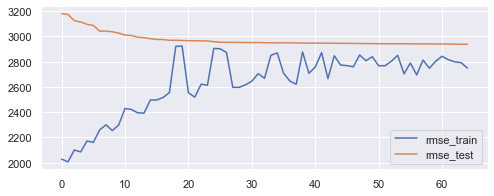

In [152]:
a = summary[['rmse_train','rmse_test']].sort_values(by='rmse_test',ascending=False).reset_index().drop('index',axis=1)
# print('Best model: {}'.format(a[0]))
a.plot()
plt.show()

In [151]:
summary['change'] = (summary['rmse_test']/summary['rmse_train'])-1
# para evitar overfitting
msk = summary['change']<0.1
summary[msk].sort_values(by='rmse_test')

,id,time,conf,estimators,learning_rate,depth,sample,rmse_train,rmse_test,change
38,39,82.942577,300_0.075_5_0.9,300,0.075,5,0.9,2749.519851,2937.741109,0.068456
50,51,72.987641,500_0.075_4_0.9,500,0.075,4,0.9,2792.135713,2937.863206,0.052192
20,21,23.695473,200_0.075_5_0.8,200,0.075,5,0.8,2799.164743,2939.031120,0.049967
35,36,61.390901,300_0.1_4_0.9,300,0.100,4,0.9,2815.569163,2939.457225,0.044001
34,35,39.900188,300_0.075_4_0.9,300,0.075,4,0.9,2842.793135,2940.134656,0.034242
8,9,28.752549,100_0.075_6_0.8,100,0.075,6,0.8,2804.017221,2940.310585,0.048606
36,37,47.544799,300_0.075_5_0.8,300,0.075,5,0.8,2748.263556,2940.571052,0.069974
33,34,47.396920,300_0.1_4_0.8,300,0.100,4,0.8,2812.873557,2940.634655,0.045420
24,25,39.847214,200_0.075_6_0.8,200,0.075,6,0.8,2695.369589,2941.197501,0.091204
48,49,92.310724,500_0.075_4_0.8,500,0.075,4,0.8,2789.737415,2941.300263,0.054329


In [160]:
gbm = pickle.load(open('model.sav','rb'))
rmse_train = mean_squared_error(train[y_vars], gbm.predict(train[x_vars]), squared=False)
rmse_test = mean_squared_error(test[y_vars], gbm.predict(test[x_vars]), squared=False)
print('TRAIN: {0:5,.4f} | TEST: {1:5,.4f} '.format(rmse_train,rmse_test))
importance = get_importance_vars(gbm)
importance.to_csv('final_var_imp.csv')
display(importance)

TRAIN: 2,749.5199 | TEST: 2,937.7411 


,rank,feature,importance,cum_imp
17,0,Product_Category_1,0.576108,0.576108
16,1,prod_cat_1_ord,0.283232,0.859340
15,2,Product_Category_2_X_prod_cat_1_ord,0.018274,0.877614
14,3,prod_cat_1_ord_X_prod_cat_2_ord,0.018051,0.895666
13,4,Age_X_occupation_ord,0.013142,0.908807
12,5,Product_Category_1_X_Product_Category_2,0.012131,0.920938
11,6,Occupation_X_stay_city_ord,0.011060,0.931998
10,7,Occupation_X_prod_cat_1_ord,0.009801,0.941799
9,8,prod_cat_2_ord_X_prod_cat_3_ord,0.008651,0.950450
8,9,Product_Category_2_X_Product_Category_3,0.008633,0.959082


In [180]:
df_all = pd.read_csv('txn_train.csv')
df_all = basicTransform(df_all)
df_all = missing_treatment(df_all)
df_all = FEATURE_CREATION(df_all)
df_all['pred_Purchase'] = gbm.predict(df_all[x_vars])
df_all['pred_Purchase'] = [0 if p<0 else p for p in df_all['pred_Purchase']]
df_all

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,...,occupation_d15,occupation_d16,occupation_d17,occupation_d18,occupation_d19,occupation_d20,city_category_d0,city_category_d1,city_category_d2,pred_Purchase
0,1004122,P00238542,1,1,19,2,4,0,5,14,...,0,0,0,0,1,0,0,0,1,5561.006002
1,1002348,P00111142,1,5,12,2,4,1,1,15,...,0,0,0,0,0,0,0,0,1,14033.787017
2,1002931,P00042842,1,1,4,1,2,0,5,-999,...,0,0,0,0,0,0,0,1,0,6995.992085
3,1003808,P00195342,1,2,7,0,2,1,2,5,...,0,0,0,0,0,0,1,0,0,11889.710968
4,1004950,P0099242,1,2,16,0,1,1,8,14,...,0,1,0,0,0,0,1,0,0,7625.666380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1001764,P00015542,1,1,0,1,1,0,1,2,...,0,0,0,0,0,0,0,1,0,13361.693787
49996,1005925,P00205942,0,2,0,2,1,1,5,8,...,0,0,0,0,0,0,0,0,1,6355.981612
49997,1001511,P00265742,1,3,12,2,4,1,5,12,...,0,0,0,0,0,0,0,0,1,8301.319984
49998,1003224,P00037542,0,2,14,0,3,1,1,-999,...,0,0,0,0,0,0,1,0,0,8376.395804


In [201]:
df_all['rnk_Purchase'] = pd.qcut(df_all['pred_Purchase'],10,labels=False,duplicates='drop')
summary_table = df_all[['rnk_Purchase', 'pred_Purchase','Gender','Age','Stay_In_Current_City_Years','Marital_Status',
                        'city_category_d0','city_category_d1','city_category_d2']]\
    .groupby('rnk_Purchase', as_index=False)\
    .agg({'pred_Purchase':['min','mean','max','count'],'Gender':['sum'],'Age':['mean'],
          'Stay_In_Current_City_Years':['mean'],'Marital_Status':['sum'],
          'city_category_d0':['sum'],'city_category_d1':['sum'],'city_category_d2':['sum']})
summary_table.columns = ['rnk_Purchase','min_Purchase','avg_Purchase','max_Purchase','freq','males','avg_age',
                         'avg_years_in_city','married',
                         'city0','city1','city2']
summary_table['male_pct'] = summary_table['males']/summary_table['freq']
summary_table['female_pct'] = 1-summary_table['male_pct']
summary_table['married_pct'] = summary_table['married']/summary_table['freq']
summary_table['no_married_pct'] = 1-summary_table['married_pct']
summary_table.sort_values(by='rnk_Purchase')

,rnk_Purchase,min_Purchase,avg_Purchase,max_Purchase,freq,males,avg_age,avg_years_in_city,married,city0,city1,city2,male_pct,female_pct,married_pct,no_married_pct
0,0,0.000000,2489.859117,4397.005039,5000,3582,2.214000,1.860600,1824,1717.0,1887.0,1396.0,0.716400,0.283600,0.364800,0.635200
1,1,4397.537852,5156.057760,5734.998534,5005,3630,2.443157,1.909491,2162,1673.0,2065.0,1267.0,0.725275,0.274725,0.431968,0.568032
2,2,5735.042538,6197.249738,6579.545458,4995,3632,2.491491,1.899299,2058,1222.0,2339.0,1434.0,0.727127,0.272873,0.412012,0.587988
3,3,6580.142021,6993.685212,7377.224057,5002,3617,2.588565,1.834666,2156,1303.0,2337.0,1362.0,0.723111,0.276889,0.431028,0.568972
4,4,7377.275275,7860.866625,8382.346028,4999,3610,2.655131,1.877576,2137,1095.0,2076.0,1828.0,0.722144,0.277856,0.427485,0.572515
5,5,8382.963721,9115.110007,10016.033068,5000,3679,2.637800,1.829400,2069,1280.0,2199.0,1521.0,0.735800,0.264200,0.413800,0.586200
6,6,10016.134056,11051.422743,12243.622992,5000,3784,2.512400,1.844800,2088,1359.0,2001.0,1640.0,0.756800,0.243200,0.417600,0.582400
7,7,12245.186754,12947.581213,13559.097802,4999,4045,2.339068,1.851770,1960,1550.0,2289.0,1160.0,0.809162,0.190838,0.392078,0.607922
8,8,13559.186611,14162.408866,14842.000831,5000,4128,2.454200,1.912800,2044,1098.0,1890.0,2012.0,0.825600,0.174400,0.408800,0.591200
9,9,14842.399524,16278.910788,23816.971861,5000,4006,2.666600,1.862000,1982,1020.0,1967.0,2013.0,0.801200,0.198800,0.396400,0.603600


### Conclusiones:
* **Estrategia 1:** Incentivar a los TOP3 deciles (gold) de compra a transaccionar más o mantenerse en el mismo nivel (programas de lealtad, puntos en tarjeta de crédito, descuentos con socios comerciales, etc.)
* **Estrategia 2:** Motivar a clientes para que se vuelvan gold, por ejemplo, en el caso de las mujeres que se encuentran más concentradas en los primeros deciles, recomendar productos de alto valor enfocados en ellas. 
* Como se puede ver en la tabla de resumen, la edad promedio estaría entre los 20 y 30, lo que nos podría ayudar a identificar mejor la población de clientes que se busca ingresar.
* **Estrategia 3:** Diseñar un modelo segmentado hacia una población más rentable (male-gold) el 80% de los clientes TOP3 son hombres (80-20 rule). Posibles acciones, aumentar inversión en marketing para sus productos preferidos, incrementar los productos de las categorías más populares entre hombres. 

### Next steps:
* Aumentando el poder computacional se podría generar features para cada producto usando matrix factorization y disminuir el RMSE.
* Algoritmos de segmentación para encontrar clientes similares que permitan relizar un marketing más personalizado.
